# Cats and Dogs Classification using Machine Learning Algorithms

This notebook classifies images of cats and dogs using traditional machine learning algorithms: **Random Forest**, **K-Nearest Neighbors (KNN)**, and **Support Vector Machine (SVM)**.


In [67]:
# Thư viện
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from PIL import Image

In [ ]:
# Hàm đọc và tiền xử lý ảnh
def load_data(data_dir, img_size=(32, 32)):
    X = []
    y = []
    categories = os.listdir(data_dir)
    for category in categories:
        path = os.path.join(data_dir, category)
        label = categories.index(category)
        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"Error loading image {img_name}: File could not be read or is not an image.")
                    continue
                img = cv2.resize(img, img_size)
                img = img/255
                X.append(img)
                y.append(label)
            except Exception as e:
                print(f"Error processing image {img_name}: {e}")
    X = np.array(X).reshape(-1, img_size[0] * img_size[1])
    y = np.array(y)
    return X, y

# Đường dẫn tới thư mục huấn luyện và kiểm tra
train_data_dir = 'dataset/training_set'
test_data_dir = 'dataset/test_set'
# Load dữ liệu huấn luyện
X_train, y_train = load_data(train_data_dir)
# Load dữ liệu kiểm tra
X_test, y_test = load_data(test_data_dir)


Displaying random images from 'dataset\training_set\cats':


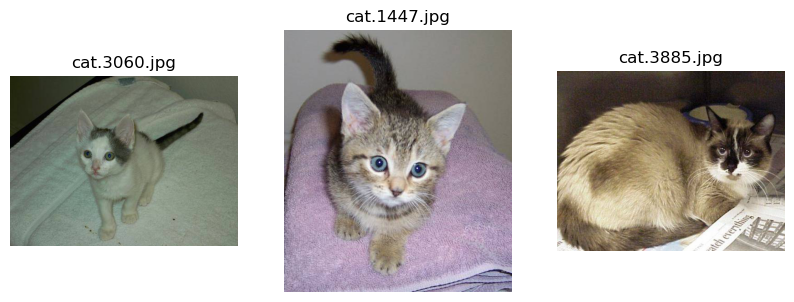

Displaying random images from 'dataset\training_set\dogs':


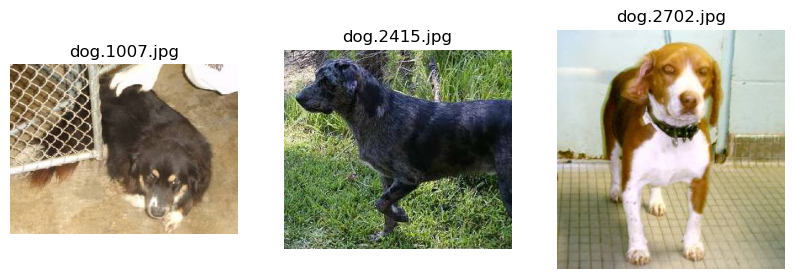

Displaying random images from 'dataset\test_set\cats':


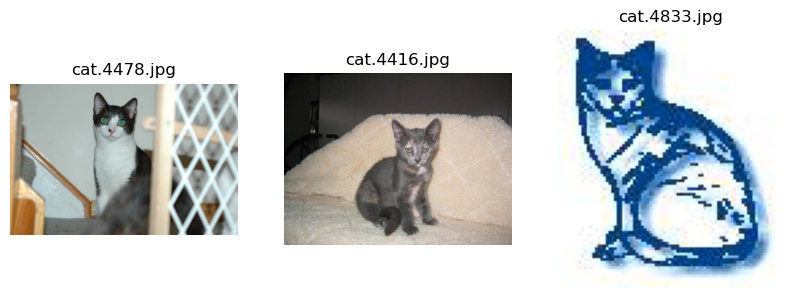

Displaying random images from 'dataset\test_set\dogs':


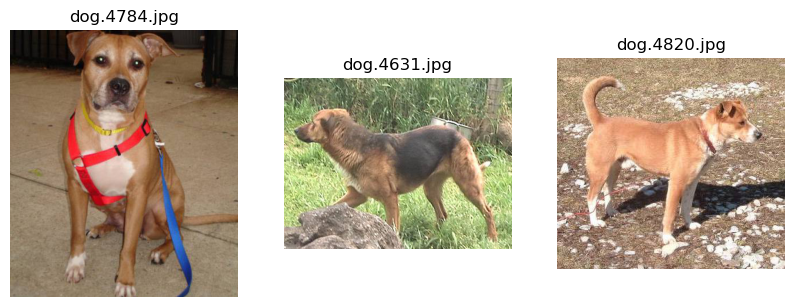

In [ ]:
# Đường dẫn cơ sở đến tập dữ liệu
dataset_path = "dataset"
sets = ["training_set", "test_set"]  
categories = ["cats", "dogs"]   # Các danh mục cần tìm trong mỗi tập hợp

# Chức năng hiển thị hình ảnh ngẫu nhiên từ mỗi danh mục
def display_random_images(folder_path, num_images=3):
    image_files = os.listdir(folder_path)
    if not image_files:
        print(f"No images found in '{folder_path}'")
        return

    # Chọn hình ảnh ngẫu nhiên từ thư mục
    random_images = random.sample(image_files, min(num_images, len(image_files)))

    # Hiển thị hình ảnh đã chọn
    plt.figure(figsize=(10, 5))
    for i, img_file in enumerate(random_images):
        img_path = os.path.join(folder_path, img_file)
        with Image.open(img_path) as img:
            plt.subplot(1, num_images, i + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"{img_file}")
    plt.show()

# Lặp lại từng tập hợp (đào tạo và kiểm tra) và từng danh mục trong tập hợp
for data_set in sets:
    for category in categories:
        folder_path = os.path.join(dataset_path, data_set, category)
        if not os.path.exists(folder_path):
            print(f"Folder '{folder_path}' not found.")
            continue

        # Hiển thị một vài hình ảnh ngẫu nhiên từ thư mục danh mục hiện tại
        print(f"Displaying random images from '{folder_path}':")
        display_random_images(folder_path, num_images=3)


In [ ]:
# Giảm chiều dữ liệu bằng PCA
pca = PCA(n_components=50)
scaler = StandardScaler()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_train_small, _, y_train_small, _ = train_test_split(X_train_pca, y_train, train_size=0.7, random_state=42)

In [ ]:
import numpy as np
from collections import Counter

# Hàm tính toán độ hỗn loạn (gini impurity)
def gini_impurity(y):
    counts = Counter(y)
    impurity = 1
    for label in counts:
        prob_of_label = counts[label] / len(y)
        impurity -= prob_of_label**2
    return impurity

# Hàm tạo một nút cây quyết định
class DecisionNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

# Hàm xây dựng cây quyết định
def build_tree(X, y, depth=0, max_depth=5):
    if depth == max_depth or len(set(y)) == 1:
        return DecisionNode(value=Counter(y).most_common(1)[0][0])

    n_samples, n_features = X.shape
    best_gini = float('inf')
    best_split = None

    for feature in range(n_features):
        thresholds = np.unique(X[:, feature])
        for threshold in thresholds:
            left_indices = X[:, feature] <= threshold
            right_indices = X[:, feature] > threshold

            if sum(left_indices) == 0 or sum(right_indices) == 0:
                continue

            left_gini = gini_impurity(y[left_indices])
            right_gini = gini_impurity(y[right_indices])
            weighted_gini = (sum(left_indices) * left_gini + sum(right_indices) * right_gini) / n_samples

            if weighted_gini < best_gini:
                best_gini = weighted_gini
                best_split = {
                    'feature': feature,
                    'threshold': threshold,
                    'left': left_indices,
                    'right': right_indices
                }

    left = build_tree(X[best_split['left']], y[best_split['left']], depth + 1, max_depth)
    right = build_tree(X[best_split['right']], y[best_split['right']], depth + 1, max_depth)
    return DecisionNode(feature=best_split['feature'], threshold=best_split['threshold'], left=left, right=right)

# Hàm dự đoán cho một mẫu đơn
def predict_tree(node, sample):
    if node.value is not None:
        return node.value
    if sample[node.feature] <= node.threshold:
        return predict_tree(node.left, sample)
    else:
        return predict_tree(node.right, sample)

# Lớp xây dựng mô hình Random Forest
class RandomForest:
    def __init__(self, n_trees=10, max_depth=5):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        for _ in range(self.n_trees):
            # Bootstrapping mẫu ngẫu nhiên
            indices = np.random.choice(len(X), len(X), replace=True)
            X_sample, y_sample = X[indices], y[indices]
            tree = build_tree(X_sample, y_sample, max_depth=self.max_depth)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([predict_tree(tree, sample) for tree in self.trees for sample in X])
        tree_preds = tree_preds.reshape(self.n_trees, X.shape[0])
        final_preds = [Counter(tree_preds[:, i]).most_common(1)[0][0] for i in range(X.shape[0])]
        return final_preds

X = np.array([[2, 3], [1, 5], [2, 4], [3, 2], [3, 5]])
y = np.array([0, 1, 0, 1, 0])

model = RandomForest(n_trees=3, max_depth=2)
model.fit(X, y)

predictions = model.predict(X_test)  

# Xuất báo cáo kết quả của Random Forest
rf_report = classification_report(y_test, predictions)
print(rf_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.50      1.00      0.67      1000

    accuracy                           0.50      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.50      0.33      2000



d:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# --- K-Nearest Neighbors (KNN) Model ---
print("\n--- K-Nearest Neighbors (KNN) ---")
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_pca, y_train)
y_pred_knn = knn.predict(X_test_pca)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))



--- K-Nearest Neighbors (KNN) ---
KNN Accuracy: 0.604
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.52      0.57      1000
           1       0.59      0.69      0.64      1000

    accuracy                           0.60      2000
   macro avg       0.61      0.60      0.60      2000
weighted avg       0.61      0.60      0.60      2000



In [65]:
# --- Support Vector Machine (SVM) Model ---
print("\n--- Support Vector Machine (SVM) ---")
svm = LinearSVC()
svm.fit(X_train_pca, y_train)
y_pred_svm = svm.predict(X_test_pca)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))


--- Support Vector Machine (SVM) ---
SVM Accuracy: 0.569
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.58      0.57      1000
           1       0.57      0.56      0.57      1000

    accuracy                           0.57      2000
   macro avg       0.57      0.57      0.57      2000
weighted avg       0.57      0.57      0.57      2000



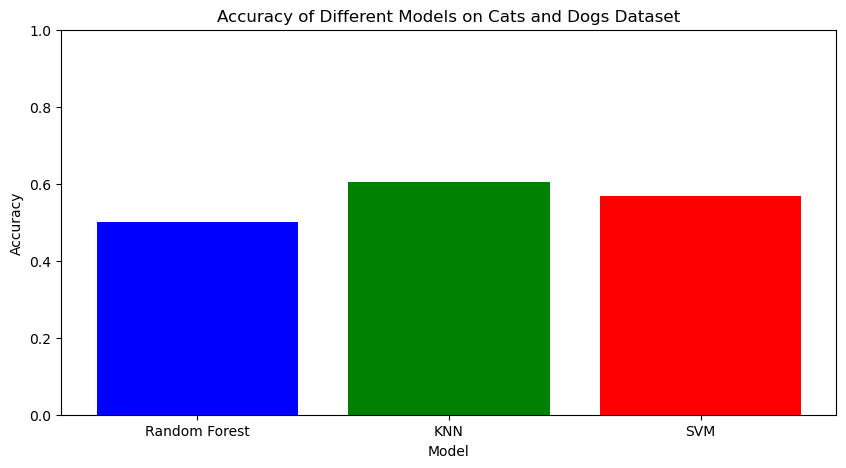

In [ ]:
# Đồ thị Accuracy
models = ['Random Forest', 'KNN', 'SVM']
accuracies = [
    accuracy_score(y_test, predictions),
    accuracy_score(y_test, y_pred_knn),
    accuracy_score(y_test, y_pred_svm)
]

plt.figure(figsize=(10, 5))
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.title('Accuracy of Different Models on Cats and Dogs Dataset')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()
